# Machine Learning Engineer Nanodegree
## Capstone Project
By Eakalak Suthampan  
December 11th, 2017

# WSDM - KKBox's Churn Prediction Challenge
Can you predict when subscribers will churn?

# Definition

## Project Overview
Customer churn prediction is essential for businesses. Early prediction of customers churn can help businesses to propose marketing campaign to prevent their customers from canceling their subscription, product or service. There are two broad approaches for churn analysis. Machine learning which we will focus and [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis). Machine learning methods, specifically classification, are widely used due to their high performance and ability to handle complex relationships in data. On the other hand, survival analyses can provide value by answering a different set of questions. Quantities, such as survival and hazard functions, can be used to forecast which customers will churn in a particular time period. 

This capstone will take the problem from the Kaggle competition ["WSDM - KKBox's Churn Prediction Challenge"](https://www.kaggle.com/c/kkbox-churn-prediction-challenge). The KKBOX is Asia’s leading music streaming service and would like to build an algorithm that predicts whether a user will churn after their subscription expires. Currently, the company uses survival analysis techniques to determine the residual membership life time for each subscriber. By adopting different methods, KKBOX anticipates they’ll discover new insights to why users leave so they can be proactive in keeping users dancing. 

## Problem Statement
The objective for the Kaggle competition ["WSDM - KKBox's Churn Prediction Challenge"](https://www.kaggle.com/c/kkbox-churn-prediction-challenge) is predicting whether a user will churn after their subscription expires. **The criteria of "churn" is no new valid service subscription within 30 days after the current membership expires.** I will build binary classification model to predict whether a user will 'churn' or 'not churn' after their subscription expires.

## Metrics
Since we would like to identify customer churn as much as possible (high [recall](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/)) while still getting acceptable [precision](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/). Therefore, I will use [f1_score](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/) as evaluation metric since the f1_score conveys the balance between the recall and the precision .

By the way, the competition use [logloss](https://www.kaggle.com/c/kkbox-churn-prediction-challenge#evaluation) as evaluation metric. logloss is more precise to measure classification performance because it is based on prediction in probabilities. I think logloss is more appropriate when using in the competition but I would like to use f1_score because I think it is more intuitive to explain to business in term of recall, precision.

# Analysis

## Data Exploration

### Datasets
There are datasets as follows. 

1. train.csv (44.5 MB, 992931 rows) is the train set. The train data consists of users whose subscription expires within the month of February 2017. 
    - msno: user id
    - is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.
1. sample_submission_zero.csv (43.5 MB, 970960 rows) is the test set. The test data is with users whose subscription expires within the month of March 2017. 
    - msno: user id
    - is_churn: This is what you will predict. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.
1. transactions.csv (1.61 GB, 21547746 rows) is transactions of users up until 2/28/2017.   
    - msno: user id
    - payment_method_id: payment method
    - payment_plan_days: length of membership plan in days
    - plan_list_price: in New Taiwan Dollar (NTD)
    - actual_amount_paid: in New Taiwan Dollar (NTD)
    - is_auto_renew
    - transaction_date: format %Y%m%d
    - membership_expire_date: format %Y%m%d
    - is_cancel: whether or not the user canceled the membership in this transaction.
1. user_logs.csv (28.4 GB, 392106543 rows) describing listening behaviors of a user. Data collected until 2/28/2017. 
    - msno: user id
    - date: format %Y%m%d
    - num_25: # of songs played less than 25% of the song length
    - num_50: # of songs played between 25% to 50% of the song length
    - num_75: # of songs played between 50% to 75% of of the song length
    - num_985: # of songs played between 75% to 98.5% of the song length
    - num_100: # of songs played over 98.5% of the song length
    - num_unq: # of unique songs played
    - total_secs: total seconds played
1. members.csv (352 MB, 5116194 rows) consist of user information. Note that not every user in the dataset is available. 
    - msno
    - city
    - bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
    - gender: this column has NULL values
    - registered_via: registration method
    - registration_init_time: format %Y%m%d
    - expiration_date: format %Y%m%d, taken as a snapshot at which the member.csv is extracted. Not representing the actual churn behavior.

There are additional datasets that were added later because the version 1 testing dataset (sample_submission_zero.csv) were leaked. So Kaggle provided the new version 2 test dataset and more training sets as folows.

6. sample_submission_v2.csv (40.6 MB) is the new test dataset for April, 2017. (replaced sample_submission_zero.csv)
7. train_v2.csv (43.5 MB) contains additional churn data for March, 2017.
8. transactions_v2.csv (110 MB) contains additional transactions data until 3/31/2017.
9. user_logs_v2.csv (1.33 GB) contains additional user logs data until 3/31/2017.
10. members_v3.csv (408 MB) is the new member dataset. (replaced members.csv)

for more information about the datasets please see at the Kaggle competition ["WSDM - KKBox's Churn Prediction Challenge"](https://www.kaggle.com/c/kkbox-churn-prediction-challenge).

### Feature Engineering

I managed to create the following new features from transactions.csv.

- last transaction for each user: I guess that features such as payment_method_id, payment_plan_days, is_auto_renew, membership_expire_date, is_cancel may effect the churn.
- subscribe duration: If users have been subscribed for a long time, they should have less chance to churn.
- oldest transaction date for each user: Some users may have very oldest transaction date but a short subscribe duration. 
- count of transactions for each user: may be the more transactions, the less likely to churn.

I managed to create the following new features from user_logs.csv.

- aggregate values such as total seconds played, total songs played for each user may effect the churn.
- count of all logs for each user. This can tell number of activities for a user.
- count of logs for the last 1 month for each user. If users don't have much activities in the last month (small log counts) they might have more chance to churn.

Finally, I merge all above features to the members.csv. Informations in the members.csv such as user age and registration method may effect the churn. For all merging, I use left join to merge features so there are NAN values for records that cannot be merged. 


In [1]:
## read train and test
import pandas as pd
datapath = 'D:/WSDM_Churn_Prediction/'

train = pd.read_csv(datapath+'train.csv')
train = pd.concat([train, pd.read_csv(datapath+'train_v2.csv')], axis=0, ignore_index=True)
test = pd.read_csv(datapath+'sample_submission_v2.csv')

In [2]:
## create last transaction features
transaction = pd.read_csv(datapath+'transactions.csv')
transaction = pd.concat([transaction, pd.read_csv(datapath+'transactions_v2.csv')], axis=0, ignore_index=True)
transaction = transaction.sort_values(['msno','transaction_date','membership_expire_date'],ascending=False)
transaction = transaction.drop_duplicates('msno',keep='first')

train = pd.merge(train, transaction, on='msno', how='left') 
test = pd.merge(test, transaction, on='msno', how='left') 

transaction = []

In [3]:
## subscribe_days feature
subscribe_days = pd.read_csv(datapath+'transactions.csv',usecols=['msno','payment_plan_days','is_cancel'])
subscribe_days = pd.concat([subscribe_days, pd.read_csv(datapath+'transactions_v2.csv',usecols=['msno','payment_plan_days','is_cancel'])], axis=0, ignore_index=True)
subscribe_days = subscribe_days[subscribe_days.is_cancel == 0]
subscribe_days = subscribe_days[['msno','payment_plan_days']]
subscribe_days = subscribe_days.groupby(['msno']).sum().reset_index()
subscribe_days.columns = ['msno','subscribe_days']

train = pd.merge(train, subscribe_days, on='msno', how='left')
test = pd.merge(test, subscribe_days, on='msno', how='left')

subscribe_days = []

In [4]:
## oldest_transaction_date feature
oldest_transaction_date = pd.read_csv(datapath+'transactions.csv',usecols=['msno','transaction_date'])
oldest_transaction_date = pd.concat([oldest_transaction_date, pd.read_csv(datapath+'transactions_v2.csv',usecols=['msno','transaction_date'])], axis=0, ignore_index=True)

oldest_transaction_date = oldest_transaction_date.sort_values(['msno','transaction_date'],ascending=True)
oldest_transaction_date = oldest_transaction_date.drop_duplicates('msno',keep='first')
oldest_transaction_date.columns = ['msno','oldest_transaction_date']

train = pd.merge(train, oldest_transaction_date, on='msno', how='left')
test = pd.merge(test, oldest_transaction_date, on='msno', how='left')

oldest_transaction_date = []

In [5]:
## transaction count feature
transaction_count = pd.read_csv(datapath+'transactions.csv',usecols=['msno','is_cancel'])
transaction_count = pd.concat([transaction_count, pd.read_csv(datapath+'transactions_v2.csv',usecols=['msno','is_cancel'])], axis=0, ignore_index=True)
transaction_count = transaction_count[transaction_count.is_cancel == 0]
transaction_count = transaction_count.groupby(['msno']).count().reset_index()
transaction_count.columns = ['msno','transaction_count']

train = pd.merge(train, transaction_count, on='msno', how='left')
test = pd.merge(test, transaction_count, on='msno', how='left')

transaction_count = []

In [6]:
## aggregate sum of user_log 
user_log = pd.concat([chunk.groupby(['msno']).sum().reset_index() for chunk in pd.read_csv(datapath+'user_logs.csv', chunksize=50000000)])
user_log = pd.concat([user_log, pd.read_csv(datapath+'user_logs_v2.csv')], axis=0, ignore_index=True)
user_log = user_log.groupby(['msno']).sum().reset_index()
user_log = user_log.drop('date', axis=1)

train = pd.merge(train, user_log, on='msno', how='left')
test = pd.merge(test, user_log, on='msno', how='left')

user_log = []

In [7]:
## count all log 
log_count_all = pd.read_csv(datapath+'user_logs.csv', usecols=['msno'])
log_count_all = pd.concat([log_count_all, pd.read_csv(datapath+'user_logs_v2.csv', usecols=['msno'])], axis=0, ignore_index=True)
log_count_all = log_count_all.groupby(['msno']).size().reset_index(name='log_count_all')

train = pd.merge(train, log_count_all, on='msno', how='left')
test = pd.merge(test, log_count_all, on='msno', how='left')

log_count_all = []

In [8]:
## count log for last 1 month
log_count_1_month = pd.read_csv(datapath+'user_logs_v2.csv', usecols=['msno'])
log_count_1_month = log_count_1_month.groupby(['msno']).size().reset_index(name='log_count_1_month')

train = pd.merge(train, log_count_1_month, on='msno', how='left')
test = pd.merge(test, log_count_1_month, on='msno', how='left')

log_count_1_month = []

In [9]:
## merge with member data
train = pd.merge(train, pd.read_csv(datapath+'members_v3.csv'), on='msno', how='left')
test = pd.merge(test, pd.read_csv(datapath+'members_v3.csv'), on='msno', how='left')

In [10]:
## for speed, save merged dataset to file for use later 
train.to_csv(datapath+'train_saved.csv', index=False)
test.to_csv(datapath+'test_saved.csv', index=False)

%reset -f

In [11]:
## read saved merged dataset
import warnings
warnings.filterwarnings("ignore")
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display 
import datetime

datapath = 'D:/WSDM_Churn_Prediction/'
# Pretty display for notebooks
%matplotlib inline

train = pd.read_csv(datapath+'train_saved.csv')
test = pd.read_csv(datapath+'test_saved.csv')

### Training dataset information

In [12]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963891 entries, 0 to 1963890
Data columns (total 27 columns):
msno                       object
is_churn                   int64
payment_method_id          int64
payment_plan_days          int64
plan_list_price            int64
actual_amount_paid         int64
is_auto_renew              int64
transaction_date           int64
membership_expire_date     int64
is_cancel                  int64
subscribe_days             float64
oldest_transaction_date    int64
transaction_count          float64
num_25                     float64
num_50                     float64
num_75                     float64
num_985                    float64
num_100                    float64
num_unq                    float64
total_secs                 float64
log_count_all              float64
log_count_1_month          float64
city                       float64
bd                         float64
gender                     object
registered_via             float64

## Exploratory Visualization
### Labels Count
First, let see the counts of labels. You can see that the labels are very imbalanced. The count of 'is_churn'=1 (churn) is very less than 'is_churn'=0 (not churn). The prediction model may be biasd to the majority which is not churn.

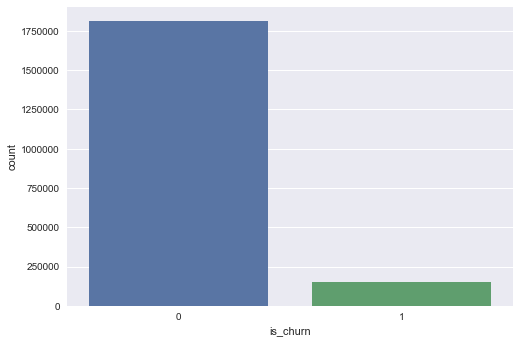

In [13]:
import seaborn as sns
#plt.rcParams["figure.figsize"] = [6,4]
ax = sns.countplot(x="is_churn", data=train)

### Count of NAN Values
There are NAN values for the merged train dataset. The gender column has NAN as majority value. The other columns have NAN values because I used left join and some users don't have associate data in users_log.csv and members.csv.

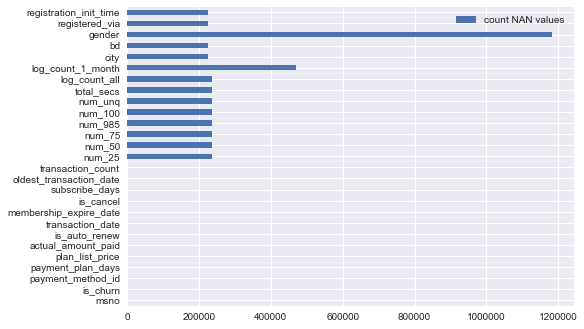

In [14]:
ax = pd.DataFrame(train.isnull().sum(), columns=['count NAN values']).plot(kind='barh')

### Count of transactions
Vilolin plot for the count of transactions for each user shows that lower transaction counts have higher probabilities to churn (is_churn=1) while higher transaction counts have higher probabilities to not churn (is_churn=0). There are many outliers for the 'is_churn=1' (long tail).

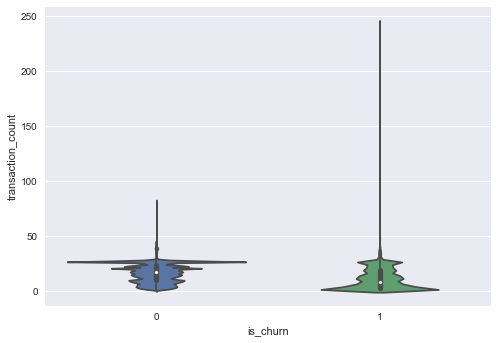

In [15]:
ax = sns.violinplot(x="is_churn", y="transaction_count", data=train)

### is_auto_renew, is_cancel

Show count plot for 'is_auto_renew' and 'is_cancel'. The plots show that 'is_cancel=1' has high effect for user to churn while 'is_auto_renew=1' has very high effect for user to not churn.

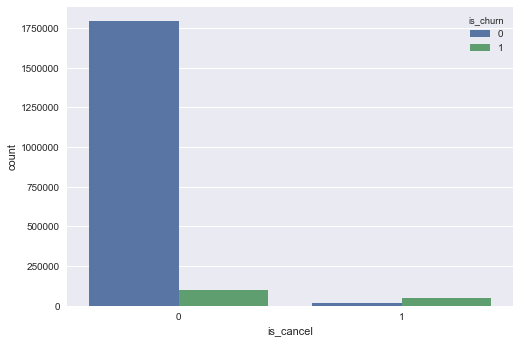

In [16]:
ax = sns.countplot(x="is_cancel", hue='is_churn',data=train)

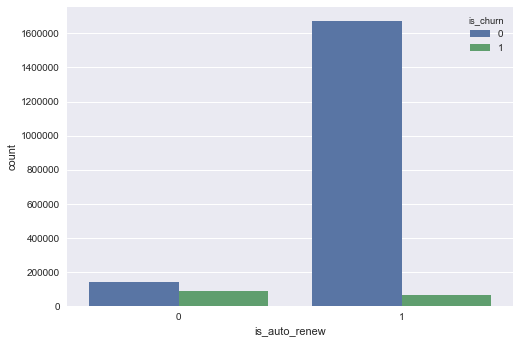

In [17]:
ax = sns.countplot(x="is_auto_renew", hue='is_churn',data=train)

### Count of last month logs
The count of last month logs means how much activities for user in the last month. From the plot, 'is_churn=1' has higher occurrence at both the top and bottom of the plot while 'is_churn=0' has very high occurrence at the top of the plot.

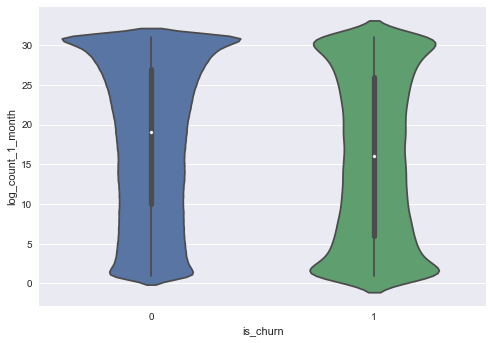

In [18]:
ax = sns.violinplot(x="is_churn", y="log_count_1_month", data=train)

## Algorithms and Techniques

First, before discussing about algorithms let's summarize the characteristics of the train data.

- very imbalanced label (churn data is very small compared to not churn data).
- have a lot of missing values. 
- many columns have outlier values.
- all columns are numeric or make sense to be numeric (for example, transaction_date, membership_expire_date).

From the characteristics of the dataset, I think ensemble method such as Random Forest and XGBoost are the most appropriate.

- Random Forest uses bagging while XGBoost uses boosting to handle the imbalanced classification.  
- They don't need to do preprocessing steps like scaling and standardize.
- They can handle the missing values.
- XGBoost may be better in term of accuracy but need more parameter tuning than Random Forest.
- Random Forest may be better in term of less overfitting if there are outlier values.
- Randome Forest can use both numeric and category data while XGBoost can use only numeric data.
  

## Benchmark
I will use two simple benchmarks as follows

- use Dicision Tree as simple model benchmark to be compared with the Random Forest and XGBoost.
- use a simple rule, if a user has no activities in the last 30 days then predict the user as churn. 

# Methodology

## Data Preprocessing

I will do the following data preprocessing.

- convert column gender from category to be numeric (1=male, 2=female) because XGBoost need all features to be numeric.
- drop msno column which is user id (does not need user id when training model). 
- Most of NAN values occured because using left join so I think it make sense to fill NAN with 0. 

XGBoost and Random Forest don't need other feature transformations such as scaling or standardizing.

In [19]:
# data preprocessing
gender = {'male':1, 'female':2}
train['gender'] = train['gender'].map(gender)
test['gender'] = test['gender'].map(gender)

train = train.drop(['msno'],axis=1)

train = train.fillna(0)
test = test.fillna(0)

## Implementation

I will do following for tuning the initial models.

- split 10% of train data to be the test data. This will be used for comparing models. 
- train and compare two models, Random Forest and XGBoost.
- tune model parameters using GridSearchCV (using small samples and small n_estimates for training speed).

### XGBoost

I will fixing the following parameters for GridSearchCV.

- n_estimators = 50 (using large n_estimators will take very long time to run)
- using 100000 records of the train data. (about 5% of train data)
- cv = 4 (cross validate)
- scoring = 'log_loss' (since Kaggle use log_loss as evaluation metric)
- objective='binary:logistic' (binary classification)

I will tune the following parameters using GridSearchCV.

- "max_depth": Maximum tree depth for base learners.
- "min_child_weight": Minimum sum of instance weight(hessian) needed in a child.
- "subsample": Subsample ratio of the training instance.
- "colsample_bytree": Subsample ratio of columns when constructing each tree.

the parameters range to tune are as follows.

- "max_depth": [4,5,6,7]
- "min_child_weight" :[1,2,3]
- "subsample": [0.6,1.0]
- "colsample_bytree": (0.6,1.0)}





In [20]:
# split test data
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(train.drop(['is_churn'],axis=1), train['is_churn'], test_size = 0.1, random_state = 0)

In [21]:
# XGBoost GridSearchCV tuning
from sklearn.model_selection import GridSearchCV
#import xgboost as xgb
from xgboost.sklearn import XGBClassifier

parameters = {"max_depth": [4,5,6,7]
            ,"min_child_weight" :[1,2,3]            
            ,"subsample": [0.6,1.0]
            ,"colsample_bytree": (0.6,1.0)}

xgb_grid_obj = GridSearchCV(XGBClassifier(objective='binary:logistic', n_estimators=50, seed=99) 
                            ,parameters, scoring='log_loss', n_jobs = 4, cv = 4)
xgb_grid_fit = xgb_grid_obj.fit(X_train[1:100000],y_train[1:100000])

The best parameters from GridSearchCV are

In [22]:
xgb_best = xgb_grid_obj.best_estimator_
xgb_grid_obj.best_params_

{'colsample_bytree': 1.0,
 'max_depth': 6,
 'min_child_weight': 1,
 'subsample': 0.6}

The first tuning scores on the train data are

In [23]:
from sklearn.metrics import recall_score,f1_score,log_loss
xgb_first_train_score1 = log_loss(y_train[1:100000], xgb_best.predict_proba(X_train[1:100000]))
xgb_first_train_score2 = recall_score(y_train[1:100000], xgb_best.predict(X_train[1:100000]))
xgb_first_train_score3 = f1_score(y_train[1:100000], xgb_best.predict(X_train[1:100000]))

print("log_loss = {}, recall = {}, f1_score = {}".format(xgb_first_train_score1, xgb_first_train_score2, xgb_first_train_score3))

log_loss = 0.0744267875661, recall = 0.757172395968, f1_score = 0.809142383649


The first tuning scores on the test data are

In [24]:
xgb_first_test_score1 = log_loss(y_test, xgb_best.predict_proba(X_test))
xgb_first_test_score2 = recall_score(y_test, xgb_best.predict(X_test))
xgb_first_test_score3 = f1_score(y_test, xgb_best.predict(X_test))

print("log_loss = {}, recall = {}, f1_score = {}".format(xgb_first_test_score1, xgb_first_test_score2, xgb_first_test_score3))

log_loss = 0.0793903277045, recall = 0.71131547381, f1_score = 0.766039902397


### Random Forest

I will fixing the following parameters for GridSearchCV.

- n_estimators = 50 (using large n_estimators will take very long time to run)
- using 100000 records of the train data (about 5% of train data).
- cv = 4 (cross validate)
- scoring = 'log_loss' (since Kaggle use log_loss as evaluation metric)

I will tune the following parameters using GridSearchCV.

- max_features: The number of features to consider when looking for the best split.
- max_depth: The maximum depth of the tree.
- min_samples_leaf: The minimum number of samples required to be at a leaf node.
- min_samples_split: The minimum number of samples required to split an internal node.


the parameters range to tune are as follows.

- "max_depth": [4,5,6]
- "min_samples_split" :[2,3,4]
- "min_samples_leaf": [1,3,5]
- "max_features": (4,5,6)

I intent to tune Random Forest to less overfit than XGBoost to compare results when submiting to Kaggle.

In [25]:
# grid search best parameters
from sklearn.ensemble import RandomForestClassifier

parameters = {"max_depth": [4,5,6]
            ,"min_samples_split" :[2,3,4]            
            ,"min_samples_leaf": [1,3,5]
            ,"max_features": (4,5,6)            
             }

rf_grid_obj = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=50) 
                           ,parameters, scoring='log_loss', n_jobs = 4, cv = 4)
rf_grid_fit = rf_grid_obj.fit(X_train[1:100000],y_train[1:100000])

The best parameters from GridSearchCV are

In [26]:
rf_best = rf_grid_obj.best_estimator_
rf_grid_obj.best_params_

{'max_depth': 6,
 'max_features': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 4}

The first scores on the train data are

In [27]:
rf_first_train_score1 = log_loss(y_train[1:100000], rf_best.predict_proba(X_train[1:100000]))
rf_first_train_score2 = recall_score(y_train[1:100000], rf_best.predict(X_train[1:100000]))
rf_first_train_score3 = f1_score(y_train[1:100000], rf_best.predict(X_train[1:100000]))

print("log_loss = {}, recall = {}, f1_score = {}".format(rf_first_train_score1, rf_first_train_score2, rf_first_train_score3))

log_loss = 0.0867531737872, recall = 0.719048849832, f1_score = 0.777692361451


The first scores on the test data are

In [28]:
rf_first_test_score1 = log_loss(y_test, rf_best.predict_proba(X_test))
rf_first_test_score2 = recall_score(y_test, rf_best.predict(X_test))
rf_first_test_score3 = f1_score(y_test, rf_best.predict(X_test))

print("log_loss = {}, recall = {}, f1_score = {}".format(rf_first_test_score1, rf_first_test_score2, rf_first_test_score3))

log_loss = 0.0879615918596, recall = 0.703851792616, f1_score = 0.762709416522


## Refinement

For final tuning, I will use parameters from the previous GridSearchCV and do following to tune the final scores.

- increase n_estimates to be 500 for both XGBoost and Random Forest.
- train on the full train data. 
- use the same test data as previous phase.

### XGBoost
The final scores on the test data are

In [29]:
xgb_best.set_params(n_estimators=500,nthread=4)
xgb_best.fit(X_train,y_train)

xgb_final_test_score1 = log_loss(y_test, xgb_best.predict_proba(X_test))
xgb_final_test_score2 = recall_score(y_test, xgb_best.predict(X_test))
xgb_final_test_score3 = f1_score(y_test, xgb_best.predict(X_test))

print("log_loss = {}, recall = {}, f1_score = {}".format(xgb_final_test_score1, xgb_final_test_score2, xgb_final_test_score3))

log_loss = 0.0747653657696, recall = 0.726042916167, f1_score = 0.770590939633


### Random Forest

The final scores on the test data are

In [30]:
rf_best.set_params(n_estimators=500,n_jobs=4)
rf_best.fit(X_train,y_train)

rf_final_test_score1 = log_loss(y_test, rf_best.predict_proba(X_test))
rf_final_test_score2 = recall_score(y_test, rf_best.predict(X_test))
rf_final_test_score3 = f1_score(y_test, rf_best.predict(X_test))

print("log_loss = {}, recall = {}, f1_score = {}".format(rf_final_test_score1, rf_final_test_score2, rf_final_test_score3))

log_loss = 0.0878255882893, recall = 0.711781953885, f1_score = 0.764785908635


### Scores Summary

Compare scores for intermediate tuning on both train and test data and final tuning on test data. 

for XGBoost

In [31]:
# convert df to markdown so that table can display when export to pdf
def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    display(Markdown(df_formatted.to_csv(sep="|", index=False)))

In [32]:
xgb_scores = pd.DataFrame(data = {'metrics': ['log_loss','recall','f1_score']})
xgb_scores['first_score_on_train_data'] = [xgb_first_train_score1,xgb_first_train_score2,xgb_first_train_score3]
xgb_scores['first_score_on_test_data'] = [xgb_first_test_score1,xgb_first_test_score2,xgb_first_test_score3]
xgb_scores['final_score_on_test_data'] = [xgb_final_test_score1,xgb_final_test_score2,xgb_final_test_score3]

#pandas_df_to_markdown_table(xgb_scores)
xgb_scores

,metrics,first_score_on_train_data,first_score_on_test_data,final_score_on_test_data
0,log_loss,0.074427,0.079390,0.074765
1,recall,0.757172,0.711315,0.726043
2,f1_score,0.809142,0.766040,0.770591


for Random Forest


In [33]:
rf_scores = pd.DataFrame(data = {'metrics': ['log_loss','recall','f1_score']})
rf_scores['first_score_on_train_data'] = [rf_first_train_score1,rf_first_train_score2,rf_first_train_score3]
rf_scores['first_score_on_test_data'] = [rf_first_test_score1,rf_first_test_score2,rf_first_test_score3]
rf_scores['final_score_on_test_data'] = [rf_final_test_score1,rf_final_test_score2,rf_final_test_score3]

#pandas_df_to_markdown_table(rf_scores)
rf_scores

,metrics,first_score_on_train_data,first_score_on_test_data,final_score_on_test_data
0,log_loss,0.086753,0.087962,0.087826
1,recall,0.719049,0.703852,0.711782
2,f1_score,0.777692,0.762709,0.764786


For both XGBoost and Random Forest, the scores on both train and test data are very close and seem not overfit. XGBoost final results on the test data have better scores than Random Forest.

In [34]:
## here are code for submitting results to Kaggle

# XGBoost
xgb_best.set_params(n_estimators=500,nthread=4)
xgb_best.fit(train.drop(['is_churn'],axis=1),train['is_churn'])
pred = xgb_best.predict_proba(test.drop(['msno','is_churn'],axis=1))
test['is_churn'] = [p[1] for p in pred]
test[['msno','is_churn']].to_csv('xgb.csv.gz', index=False, compression='gzip')

# Random Forest
rf_best.set_params(n_estimators=500,n_jobs=4)
rf_best.fit(train.drop(['is_churn'],axis=1),train['is_churn'])
pred = rf_best.predict_proba(test.drop(['msno','is_churn'],axis=1))
test['is_churn'] = [p[1] for p in pred]
test[['msno','is_churn']].to_csv('rf.csv.gz', index=False, compression='gzip')

# Results


## Model Evaluation and Validation

I submitted results from both XGBoost and Random Forest to Kaggle. The best result is from Random Forest model which I got 55th place out of 434 on the Kaggle public leaderboard (As of DEC 7, 2017). 

![](lb.jpg)

In [35]:
results = pd.DataFrame(data={'Model':['XGBoost','Random Forest']
                             ,'log_loss_on_the_test_data':[xgb_final_test_score1,rf_final_test_score1]
                             ,'log_loss_on_Kaggle_public_leaderboard':[0.14421,0.12714]})
#pandas_df_to_markdown_table(results)
results

,Model,log_loss_on_Kaggle_public_leaderboard,log_loss_on_the_test_data
0,XGBoost,0.14421,0.074765
1,Random Forest,0.12714,0.087826


It's surprised me that Random Forest got higher score on Kaggle Public Leaderboard although XGBoost got higher score on the test data. It seems that both models are overfit to the real data but Random Forest is less overfit than XGBoost. I think the reason that Random Forest is less overfit is because both model have the parameter 'maxdepth' equally which is 6 so Random Forest which is bagging seem to less overfit than XGBoost which is boosting.

So my final chosen model is Random Forest because in real life many of user churn may don't have exact pattern so the less overfit model should be better.

## Justification

I have the following benchmarks.

- benchmark1: use a simple decision tree.
- benchmark2: use a simple rule if user does not have usage log in the last month then predict user to churn.

Here are results of bechmarks to compare with the final chosen model.

In [36]:
# benchmark1 Decision Tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train,y_train)

benchmark1_score1 = log_loss(y_test, dt.predict_proba(X_test))
benchmark1_score2 = recall_score(y_test, dt.predict(X_test))
benchmark1_score3 = f1_score(y_test, dt.predict(X_test))

In [37]:
# benchmark2 simple rule if user does not have usage log for the last month then predict user to churn
pred = [1 if i==0 else 0 for i in X_test['log_count_1_month']]
benchmark2_score1 = log_loss(y_test, pred)
benchmark2_score2 = recall_score(y_test, pred)
benchmark2_score3 = f1_score(y_test, pred)

In [38]:
results = pd.DataFrame({'model':['benchmark1','benchmark2','Random Forest']})
results['log_loss'] = [benchmark1_score1,benchmark2_score1,rf_final_test_score1]
results['recall'] = [benchmark1_score2,benchmark2_score2,rf_final_test_score2]
results['f1_score'] =[benchmark1_score3,benchmark2_score3,rf_final_test_score3]
#pandas_df_to_markdown_table(results)
results

,model,log_loss,recall,f1_score
0,benchmark1,1.725179,0.625883,0.639891
1,benchmark2,8.747856,0.413568,0.199704
2,Random Forest,0.087826,0.711782,0.764786


- benchmark1 and benchmark2 cannot predict in probabilities so their log_loss are very high.
- benchmark1 has both recall and f1_core significantly lower than Random Forest. 
- benchmark2 has both recall and f1_core significantly lower than Random Forest. Especially the very low f1_score compared to recall tells that it has very low precision (high False Positive).
- Random Forest has high enough scores on both recall and f1_score which means it can effectively identify around 71 out of 100 for the churn users while still maintain acceptable false alarm.

# Conclusion

## Free-Form Visualization


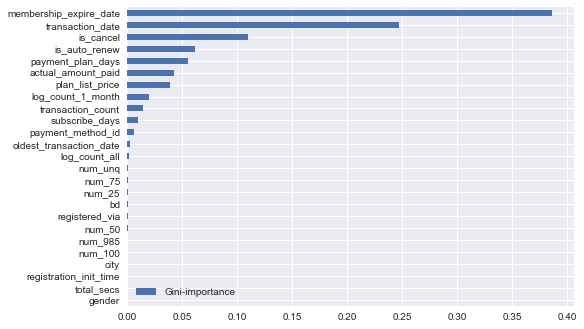

In [39]:
feats = {} 
for feature, importance in zip(X_train.columns, rf_best.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
ax = importances.sort_values(by='Gini-importance').plot(kind='barh')

Feature importances plot shows that 'membership_expire_date', 'transaction_date' and 'is_cancel' are the top 3 most important features to predict customer churn. Most of important features are from transactions.csv. Features from user_log.csv and members.csv are almost no importance.

## Reflection

I think there are three difficult parts. 

- The first one is about feature engineering which I need to merge many associated datasets together to create new useful features. Since the datasets are very large so it take very long time to process using my laptop. 
- The second one is the tuning step since it's imbalanced classification problem so the model may bias to the majority class label which is 'not churn'. 
- The third one is the model overfit when I submited my predictions to Kaggle. It's may be because there are many outliers for churn users (please see in the plot transaction counts). Random Forest has less overfiting compared to XGBoost.
- Although the final model is overfit but not significantly and the model still much better than using the basic benchmarks.


## Improvement

To improve the model I will focus on reducing overfit.

- Explore and filter out more outlier values.
- Remove unnecessary features based on the feature importances plot.
- Tuning parameters that effect the overfit such as reducing maxdepth.
- Try early stoping technique in XGBoost which can help preventing overfit.
- Train with more data if possible to make model more generalize.
- Try to create new feature that does not depend on date value and not strong correlate with the existing features.

